In [2]:
import sqlite3 as sql_client
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [30]:
SQL_DB_FILE_PATH='./FPA_FOD_20170508.sqlite'

causes_map = {
  'Miscellaneous': 0,
  'Lightning': 1,
  'Debris Burning': 2,
  'Campfire': 3,
  'Equipment Use': 4,
  'Arson': 5,
  'Children': 6,
  'Railroad': 7,
  'Smoking': 8,
  'Powerline': 9,
  'Structure': 10,
  'Fireworks': 11,
  'Missing/Undefined': 12
}


In [31]:
def set_causes_map(data_frame, description):
  causes_set = set(data_frame['cause'])
  causes_map = dict(zip(causes_set, range(len(causes_set))))

In [32]:
def display_rows(data_frame, description):
  print('='*88)
  print('Description: ' + description)
  print('Result:')
  print(data_frame.to_string())

In [33]:
def train_and_test(data_frame, description):
  data_frame = data_frame.dropna()
  data_frame['cause'] = data_frame['cause'].map(causes_map)
  X = data_frame.drop(['cause'], axis=1).values
  Y = data_frame['cause'].values
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0) # 80% to train; 20% test
  classifier = RandomForestClassifier(n_estimators=200).fit(X_train, Y_train)
  score = classifier.score(X_test, Y_test) * 100
  print('Test Set Score: {} %'.format(score))


In [34]:
queries_and_executors = [
  [
    """
    SELECT fire_year, COUNT(*) as incident_count
    FROM fires
    GROUP BY fire_year
    ORDER BY fire_year ASC
    """, 
    'Have wildfires become more or less frequent over time?',
    display_rows
  ],
  [
    """
    SELECT county, COUNT(*) as incident_count
    FROM fires
    GROUP BY county
    ORDER BY incident_count DESC
    """,
    'What counties are the most and least fire-prone?',
    display_rows
  ],
  # distinct query will read the entire table, better to use it once and update the local values
  [
    """
    SELECT stat_cause_descr as cause
    FROM fires
    LIMIT 100
    """, 
    'All Causes',
    set_causes_map
  ],
  [
    """
    SELECT
      latitude,
      longitude,
      fire_size as size,
      strftime('%w', discovery_date) as day_of_week,
      strftime('%m', discovery_date) as month,
      fire_year as year,
      stat_cause_descr as cause
    FROM fires
    LIMIT 50000
    """, 
    'Sample Data',
    train_and_test
  ]
]


In [36]:
connection = sql_client.connect(SQL_DB_FILE_PATH)
for query_description_executor in queries_and_executors:
  query = query_description_executor[0]
  description = query_description_executor[1]
  executor = query_description_executor[2]
  data_frame = pd.read_sql(query, con=connection)
  executor(data_frame, description)

Description: Have wildfires become more or less frequent over time?
Result:
    FIRE_YEAR  incident_count
0        1992           67975
1        1993           61989
2        1994           75955
3        1995           71472
4        1996           75574
5        1997           61450
6        1998           68370
7        1999           89363
8        2000           96416
9        2001           86587
10       2002           75656
11       2003           68261
12       2004           69279
13       2005           88604
14       2006          114004
15       2007           95573
16       2008           85378
17       2009           78325
18       2010           79889
19       2011           90552
20       2012           72769
21       2013           64780
22       2014           67753
23       2015           74491
Description: What counties are the most and least fire-prone?
Result:
                                                  COUNTY  incident_count
0                              

# Data Overview

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_sql_query("SELECT * FROM 'Fires'", connection)

In [12]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


# California Wildfire Analysis

In [14]:
ca_only = df['STATE'] == 'CA'
ca_only_ds = df[ca_only]
list(ca_only_ds)

['OBJECTID',
 'FOD_ID',
 'FPA_ID',
 'SOURCE_SYSTEM_TYPE',
 'SOURCE_SYSTEM',
 'NWCG_REPORTING_AGENCY',
 'NWCG_REPORTING_UNIT_ID',
 'NWCG_REPORTING_UNIT_NAME',
 'SOURCE_REPORTING_UNIT',
 'SOURCE_REPORTING_UNIT_NAME',
 'LOCAL_FIRE_REPORT_ID',
 'LOCAL_INCIDENT_ID',
 'FIRE_CODE',
 'FIRE_NAME',
 'ICS_209_INCIDENT_NUMBER',
 'ICS_209_NAME',
 'MTBS_ID',
 'MTBS_FIRE_NAME',
 'COMPLEX_NAME',
 'FIRE_YEAR',
 'DISCOVERY_DATE',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'STAT_CAUSE_CODE',
 'STAT_CAUSE_DESCR',
 'CONT_DATE',
 'CONT_DOY',
 'CONT_TIME',
 'FIRE_SIZE',
 'FIRE_SIZE_CLASS',
 'LATITUDE',
 'LONGITUDE',
 'OWNER_CODE',
 'OWNER_DESCR',
 'STATE',
 'COUNTY',
 'FIPS_CODE',
 'FIPS_NAME',
 'Shape']

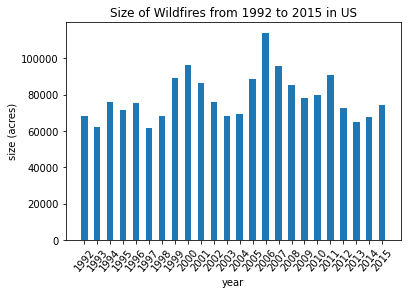

In [40]:
fire_year = df.groupby('FIRE_YEAR').size()
plt.bar(range(len(fire_year)), fire_year.values, width = 0.5)
plt.xticks(range(len(fire_year)), fire_year.index, rotation = 50)
plt.xlabel('year')
plt.ylabel('size (acres)')
plt.title("Size of Wildfires from 1992 to 2015 in US")
plt.show()

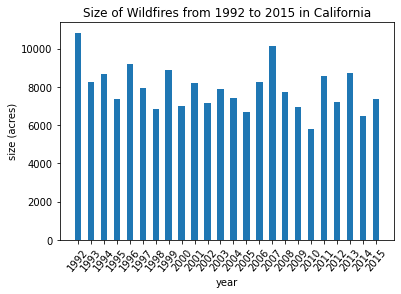

In [37]:
fire_year = ca_only_ds.groupby('FIRE_YEAR').size()
plt.bar(range(len(fire_year)), fire_year.values, width = 0.5)
plt.xticks(range(len(fire_year)), fire_year.index, rotation = 50)
plt.xlabel('year')
plt.ylabel('size (acres)')
plt.title("Size of Wildfires from 1992 to 2015 in California")
plt.show()

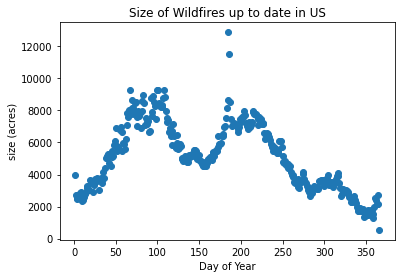

In [41]:
fire_date = df.groupby('DISCOVERY_DOY').size()
plt.scatter(fire_date.index, fire_date.values)
plt.title('Size of Wildfires up to date in US')
plt.xlabel('Day of Year')
plt.ylabel('size (acres)')
plt.show()

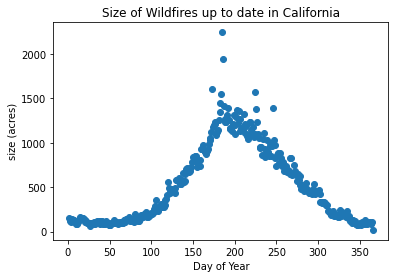

In [42]:
fire_date = ca_only_ds.groupby('DISCOVERY_DOY').size()
plt.scatter(fire_date.index, fire_date.values)
plt.title('Size of Wildfires up to date in California')
plt.xlabel('Day of Year')
plt.ylabel('size (acres)')
plt.show()

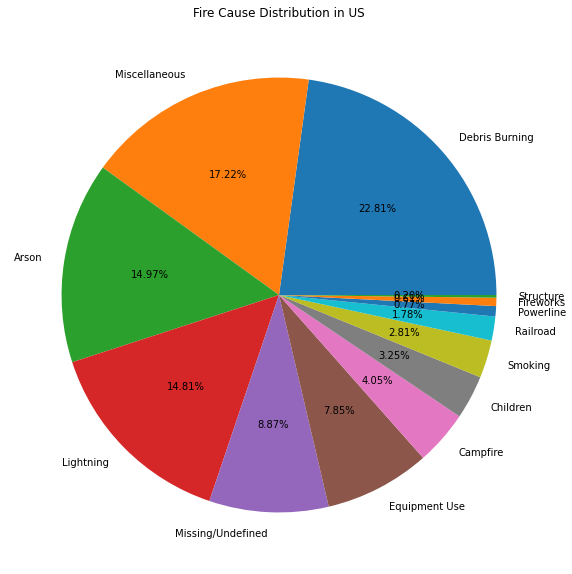

In [48]:
cause = df.STAT_CAUSE_DESCR.value_counts()
fig,ax = plt.subplots(figsize=(10,10))
ax.pie(x=cause,labels=cause.index,rotatelabels=False, autopct='%.2f%%');
plt.title('Fire Cause Distribution in US');

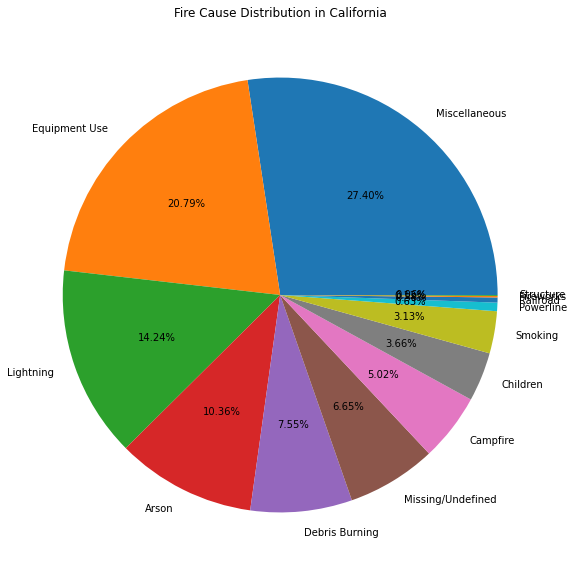

In [47]:
cause = ca_only_ds.STAT_CAUSE_DESCR.value_counts()
fig,ax = plt.subplots(figsize=(10,10))
ax.pie(x=cause,labels=cause.index,rotatelabels=False, autopct='%.2f%%');
plt.title('Fire Cause Distribution in California');

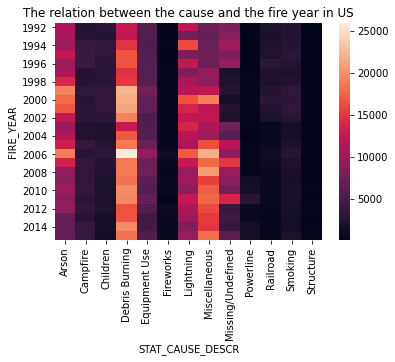

In [43]:
sns.heatmap(pd.crosstab(df.FIRE_YEAR, df.STAT_CAUSE_DESCR))
plt.title('The relation between the cause and the fire year in US')
plt.show()

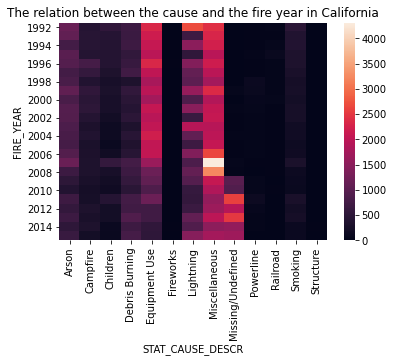

In [53]:
sns.heatmap(pd.crosstab(ca_only_ds.FIRE_YEAR, df.STAT_CAUSE_DESCR))
plt.title('The relation between the cause and the fire year in California')
plt.show()

## Calculate histograms for Miscellaneous, lightning and "equipment use" caused wildfires

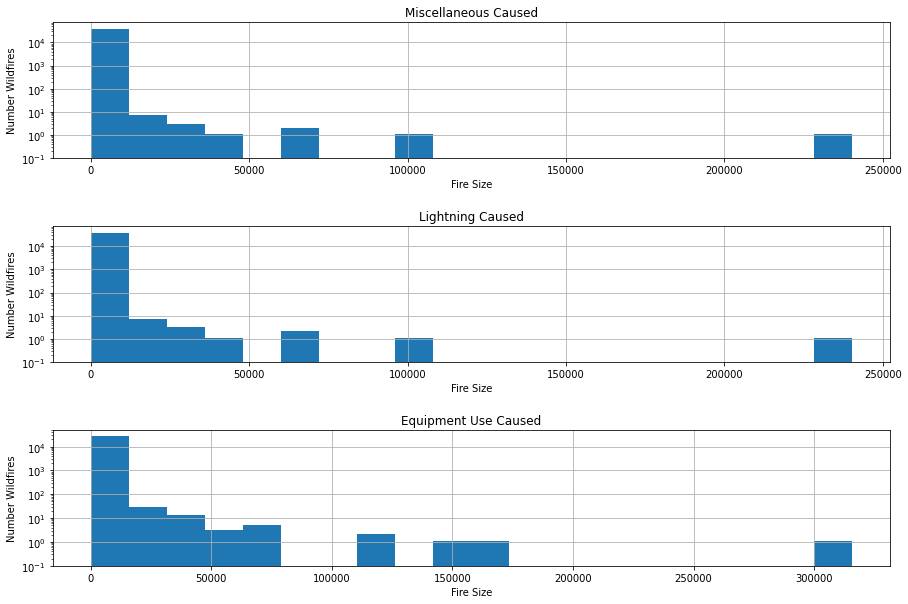

In [52]:
fig=plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.subplots_adjust(hspace=0.5)
plt.subplot(311)
plt.title('Miscellaneous Caused')
plt.xlabel('Fire Size')
plt.grid()
plt.ylabel('Number Wildfires')
plt.hist(ca_only_ds[ca_only_ds['STAT_CAUSE_DESCR'] == 'Equipment Use']['FIRE_SIZE'],bins=20,bottom=.1)
plt.semilogy()

plt.subplot(312)
plt.title('Lightning Caused')
plt.xlabel('Fire Size')
plt.grid()
plt.ylabel('Number Wildfires')
plt.hist(ca_only_ds[ca_only_ds['STAT_CAUSE_DESCR'] == 'Equipment Use']['FIRE_SIZE'],bins=20,bottom=.1)
plt.semilogy()

plt.subplot(313)
plt.title('Equipment Use Caused')
plt.xlabel('Fire Size')
plt.ylabel('Number Wildfires')
plt.grid()
plt.hist(ca_only_ds[ca_only_ds['STAT_CAUSE_DESCR'] == 'Lightning']['FIRE_SIZE'],bins=20,bottom=.1)
plt.semilogy();

   # Heat Maps

In [ ]:
import numpy as np
import colorcet as cc
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LogColorMapper

In [8]:
# read latitude/longitude/fire size/state into panda dataframe
df = pd.read_sql_query("SELECT LATITUDE, LONGITUDE, FIRE_SIZE, STATE FROM fires", connection)
# show the first 5 rows
df.head(5)

,LATITUDE,LONGITUDE,FIRE_SIZE,STATE
0,40.036944,-121.005833,0.10,CA
1,38.933056,-120.404444,0.25,CA
2,38.984167,-120.735556,0.10,CA
3,38.559167,-119.913333,0.10,CA
4,38.559167,-119.933056,0.10,CA


In [ ]:
# Remove all wildfires in Alaska, Hawaii and Puerto Rico, because they don't fit on our map nicely:
new = df.loc[(df.loc[:,'STATE']!='AK') & (df.loc[:,'STATE']!='HI') & (df.loc[:,'STATE']!='PR')]

In [ ]:
# Suppress some Pandas warning messages that are actually not relevant (false positives)
data_analyzer.options.mode.chained_assignment = None

In [ ]:
# Group wildfires together that occured near to each other.
new.loc[:,'LATITUDE'] = ((new.loc[:,'LATITUDE']*10).apply(np.floor))/10
new.loc[:,'LONGITUDE'] = ((new.loc[:,'LONGITUDE']*10).apply(np.floor))/10
new.loc[:,'LL_COMBO'] = new.loc[:,'LATITUDE'].map(str) + '-' + new.loc[:,'LONGITUDE'].map(str)
grouped = new.groupby(['LL_COMBO', 'LATITUDE', 'LONGITUDE'])

In [ ]:
# Create the datasource that is needed for the first heat maps (showing the number of wildfires per geographic location).
number_of_wf = grouped['FIRE_SIZE'].agg(['count']).reset_index()
number_of_wf.head(5)

In [ ]:
# Create the datasource that is needed for the second heat map (showing the average size of wildfires per geographic location).
size_of_wf = grouped['FIRE_SIZE'].agg(['mean']).reset_index()
size_of_wf.head(5)

In [ ]:
# Create and show the first heat map:
source = ColumnDataSource(number_of_wf)
p1 = figure(title="Number of wildfires occurring from 1992 to 2015 " + \
            "(lighter color means more wildfires)",
           toolbar_location=None, plot_width=600, plot_height=400)
p1.background_fill_color = "black"
p1.grid.grid_line_color = None
p1.axis.visible = False
color_mapper = LogColorMapper(palette=cc.fire)
glyph = p1.circle('LONGITUDE', 'LATITUDE', source=source,
          color={'field': 'count', 'transform' : color_mapper},
          size=1)
output_notebook()
show(p1)

In [ ]:
# Create and show the second heat map
source = ColumnDataSource(size_of_wf)
p2 = figure(title="Average size of wildfires occurring from 1992 to 2015 " + \
            "(lighter color means bigger fire)",
           toolbar_location=None, plot_width=600, plot_height=400)
p2.background_fill_color = "black"
p2.grid.grid_line_color = None
p2.axis.visible = False
glyph = p2.circle('LONGITUDE', 'LATITUDE', source=source,
          color={'field': 'mean', 'transform' : color_mapper},
          size=1)
show(p2)